# Étude de l'erreur due à la diffusion et à la convection dans le cas du SWARM

In [1]:
import sys

sys.path = ['/home/as259691/PycharmProjects/FluidDyn1D'] + sys.path

In [2]:
from src.main import *
from src.plot_fields import *

# %matplotlib inline
rc('figure', figsize=(10,5))
rc('figure', dpi=100)

## Paramètres de la simulation

Ici on va réaliser une simulation sans diffusion pour différentes écritures de notre équation thermique.

La résolution se fait à chaque fois en WENO avec Euler explicite en temps.

In [3]:
# d = 6./100*Delta/2.
phy_prop = PhysicalProperties(Delta=0.02, v=0.2, dS=0.005**2,
                              lda1=5.5*10**-2, lda2=15.5, rho_cp1=70278., rho_cp2=702780., diff=1.,
                              alpha=0.06, a_i=357.)
markers = Bulles(phy_prop=phy_prop)
Formulation = [Problem, ProblemConserv2]

n = 1000
t_fin = 0.02

In [4]:
def compare_energy_forme(formu, phy_prop, num_prop, markers, t_fin, t_list=None):
    fig1,ax1 = plt.subplots(1)
    ax1.set_title('Énergie en fonction du temps')
    for form in formu:
        print()
        prob = form(get_T_creneau, markers=markers, phy_prop=phy_prop, num_prop=num_prop)
        if t_list is not None:
            t_list.append(prob.dt)
        E0 = prob.energy
        print(prob.name)
        print('==========================')
        t, e = prob.timestep(t_fin=t_fin, number_of_plots=5, debug=None, plotter=Plotter('decale'))
        l = ax1.plot(t, e/(0.02*0.005*0.005), label=prob.name)
        n = len(e)
        i0 = int(n/5)
        dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob.dt / E0  # on a mult
        # par Dt / rho_cp_l T_l V
        print('dE*/dt* = %g' % dedt_adim)
    le = fig1.legend()
    ax1.minorticks_on()
    ax1.grid(b=True, which='both')
    return e[-1] - e[0]

## Étude selon la formulation de l'équation

En fait s'il n'y a pas de convection il n'y a pas de différence entre les différentes formes, à l'exception de la moyenne utilisée pour $\frac{1}{\rho C_p}$

### RK4


dt fourier
6.918433404737903e-06
Cas : mixte
dE*/dt* = -3.21138e-05

dt fourier
6.918433404737903e-06
EC, Cas : mixte
dE*/dt* = 5.34512e-05


0.004529952251615871

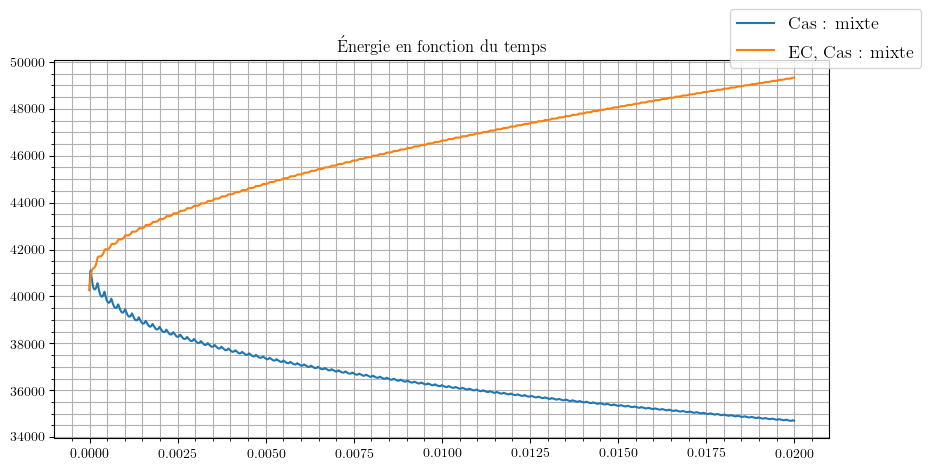

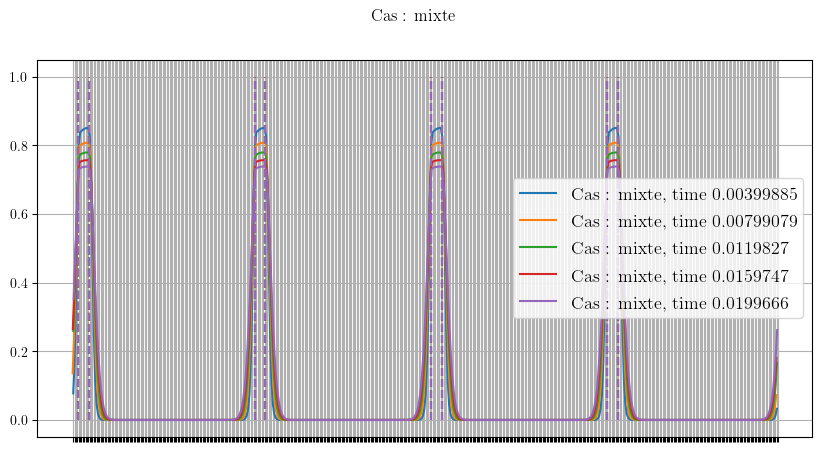

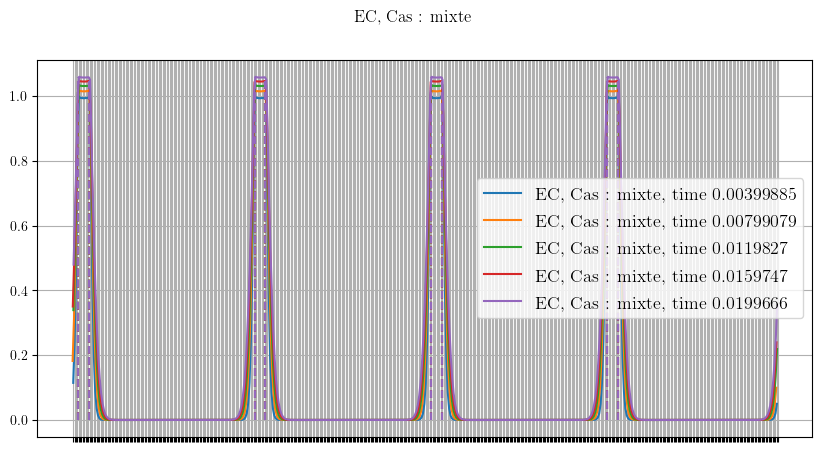

In [5]:
num_prop = NumericalProperties(dx=3.9*10**-5, schema='weno', time_scheme='rk4', phy_prop=phy_prop, cfl=0.5)
compare_energy_forme(Formulation, phy_prop, num_prop, markers, t_fin)

### Euler

In [6]:
num_prop = NumericalProperties(dx=3.9*10**-5, schema='weno', time_scheme='euler', phy_prop=phy_prop)


dt fourier
6.918433404737903e-06
Cas : mixte
dE*/dt* = -2.87567e-05

dt fourier
6.918433404737903e-06
EC, Cas : mixte
dE*/dt* = 5.5369e-05


0.004751991076580458

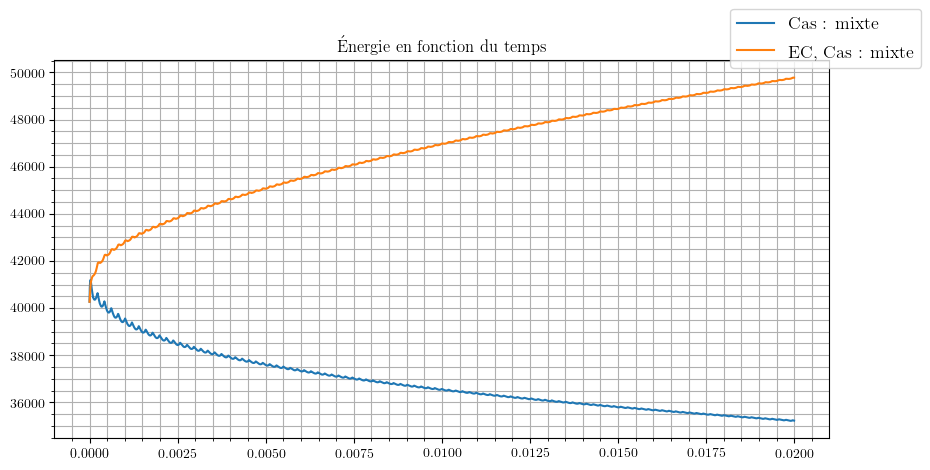

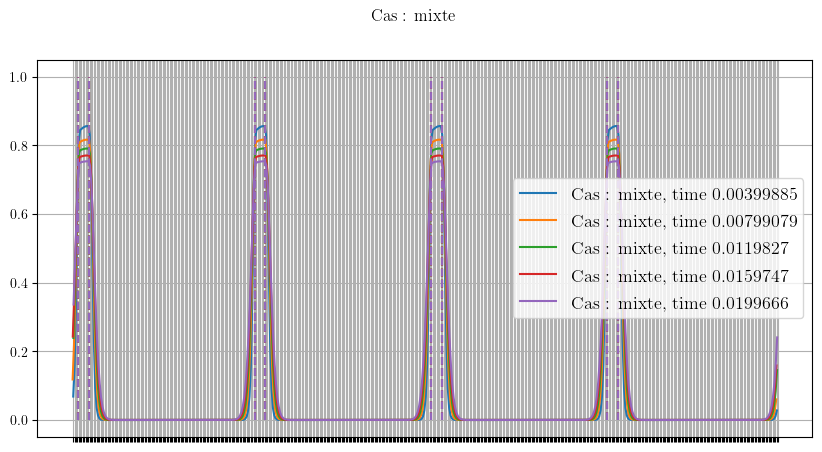

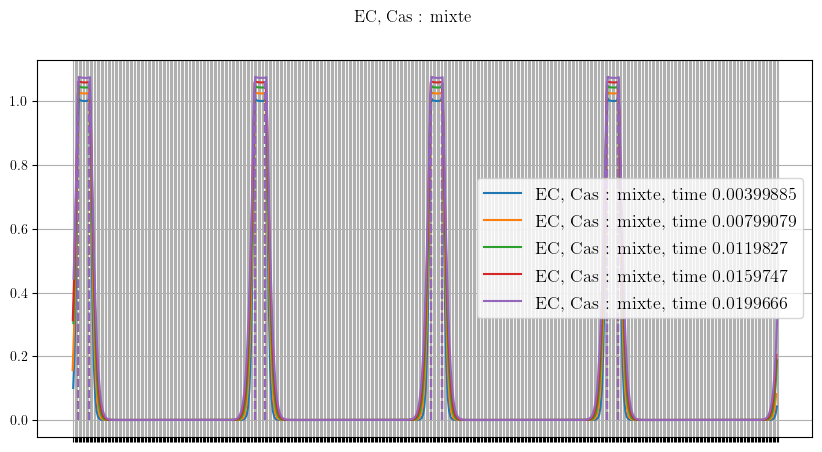

In [7]:
compare_energy_forme(Formulation, phy_prop, num_prop, markers, t_fin)

## Cas boniou, euler avec weno et upwind quand le stencil traverse l'interface


dt fourier
6.918433404737903e-06
Cas : mixte
dE*/dt* = -4.93002e-05

dt fourier
6.918433404737903e-06
EC, Cas : mixte
dE*/dt* = 2.00951e-05


0.0027804768261415064

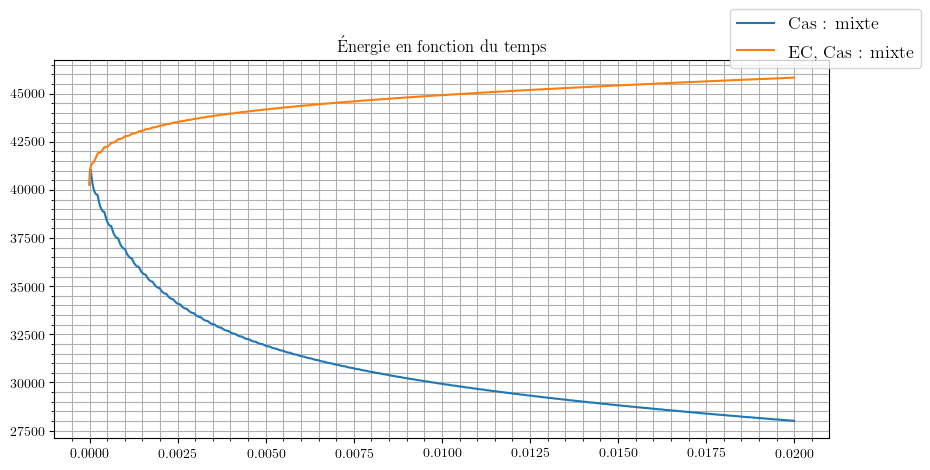

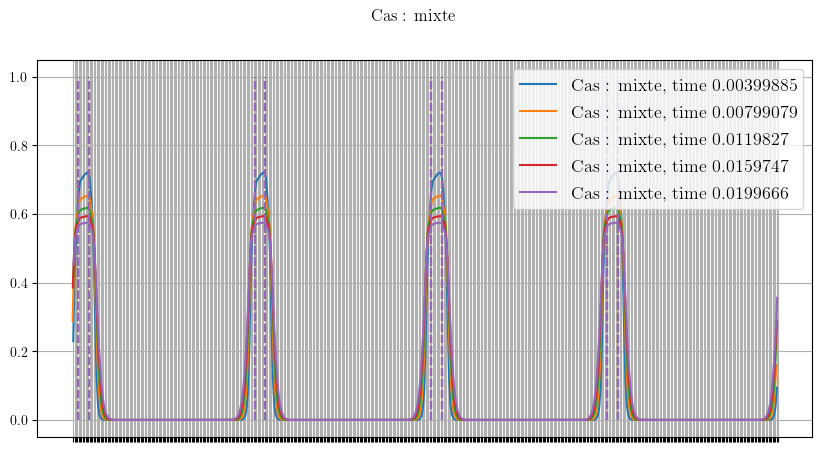

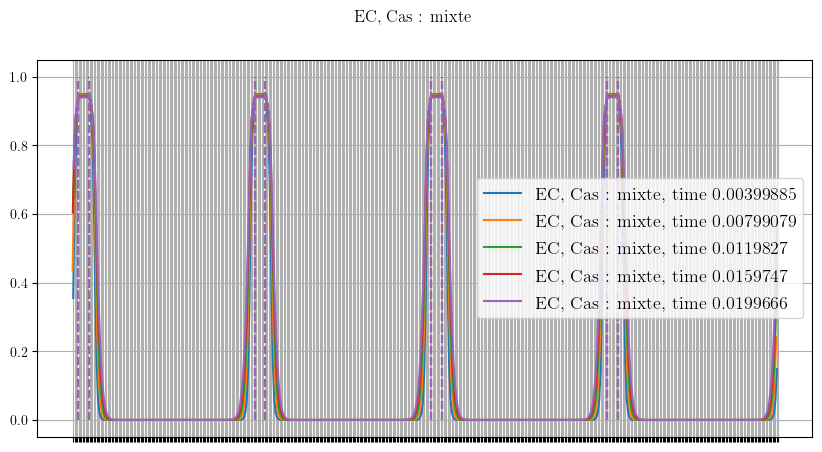

In [8]:
num_prop = NumericalProperties(dx=3.9*10**-5, schema='weno upwind', time_scheme='euler', phy_prop=phy_prop)
compare_energy_forme(Formulation, phy_prop, num_prop, markers, t_fin)

# Étude numérique

## Étude en $\Delta x$

dt fourier
1.1335161290322582e-07

dt min
1.1335161290322582e-07
Cas : mixte
dE*/dt* = -2.62768e-07

dt min
1.1335161290322582e-07
EC, Cas : mixte
dE*/dt* = 1.34775e-07

dt min
1.1335161290322582e-07
Cas : mixte
dE*/dt* = -3.35381e-07

dt min
1.1335161290322582e-07
EC, Cas : mixte
dE*/dt* = 1.56704e-07

dt min
1.1335161290322582e-07
Cas : mixte
dE*/dt* = -3.52232e-07

dt min
1.1335161290322582e-07
EC, Cas : mixte
dE*/dt* = 1.88157e-07

dt min
1.1335161290322582e-07
Cas : mixte
dE*/dt* = -3.1119e-07

dt min
1.1335161290322582e-07
EC, Cas : mixte
dE*/dt* = 2.20645e-07


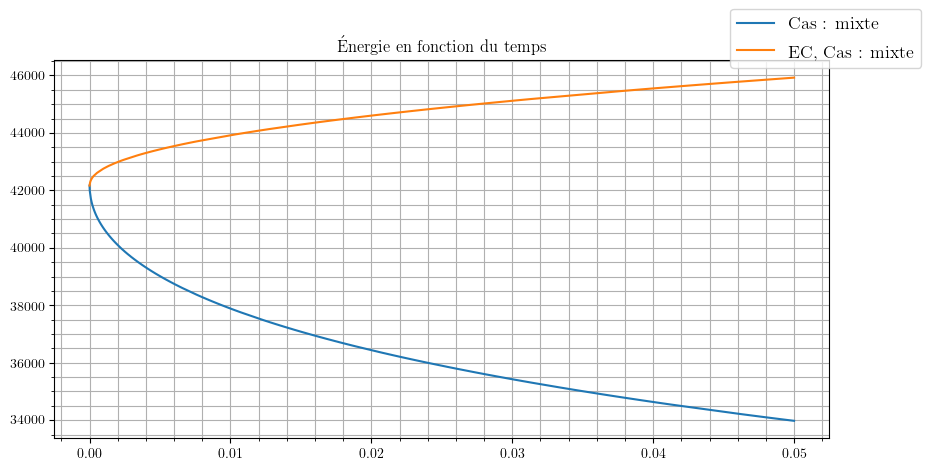

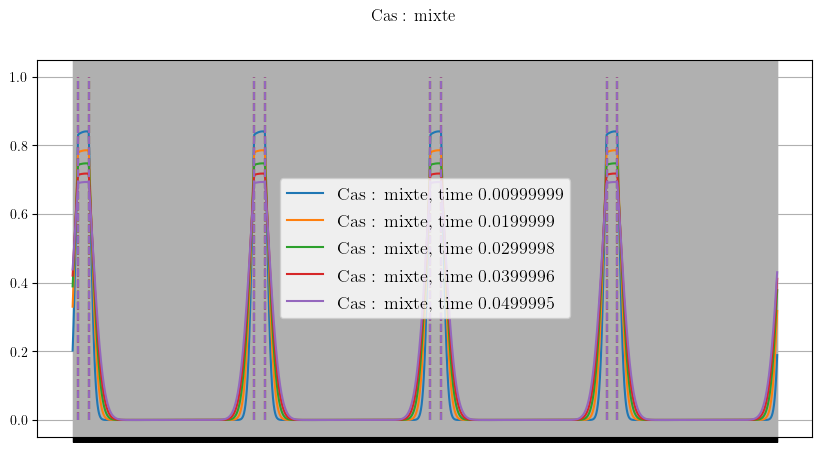

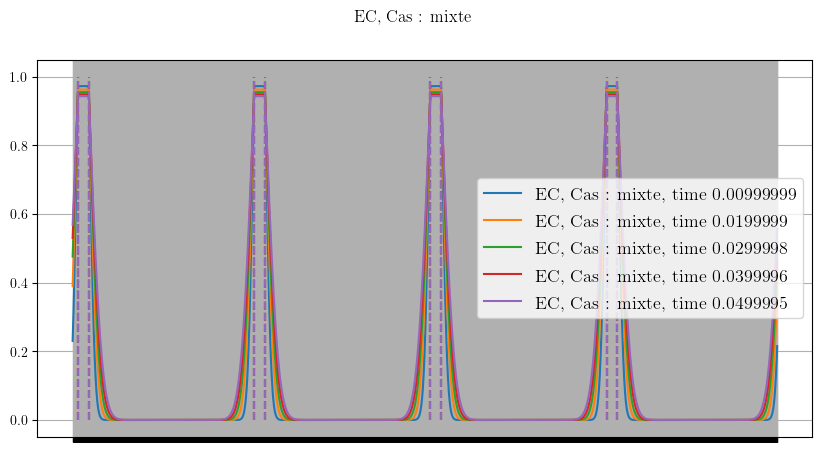

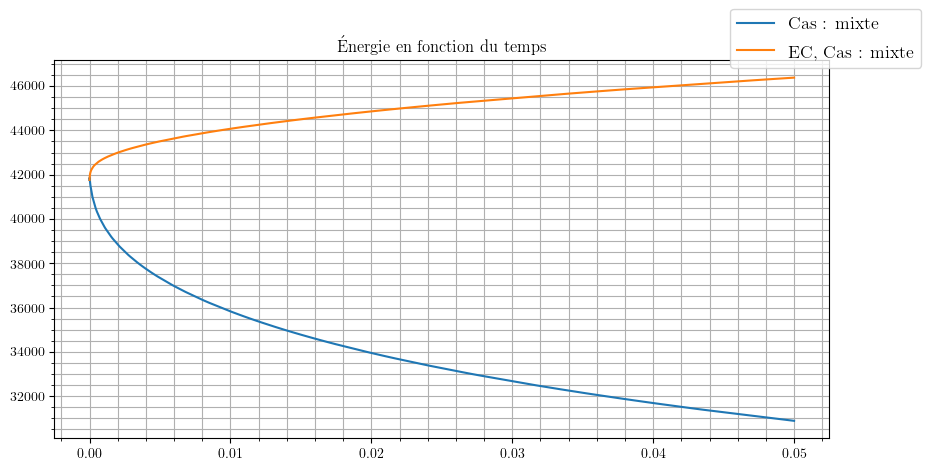

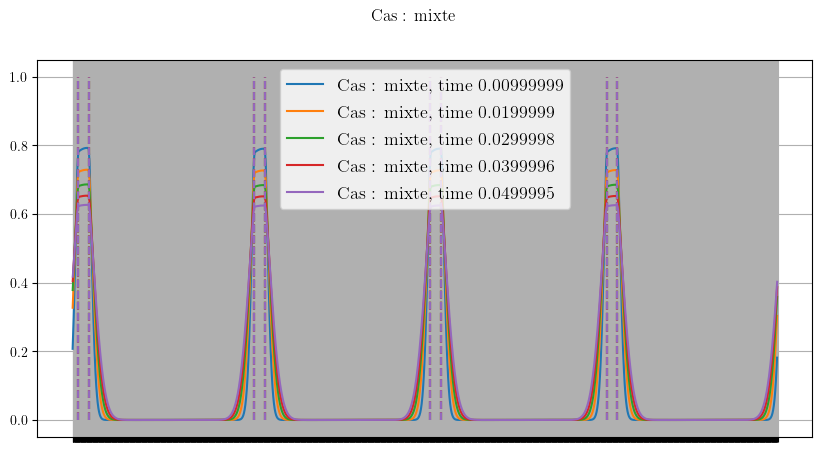

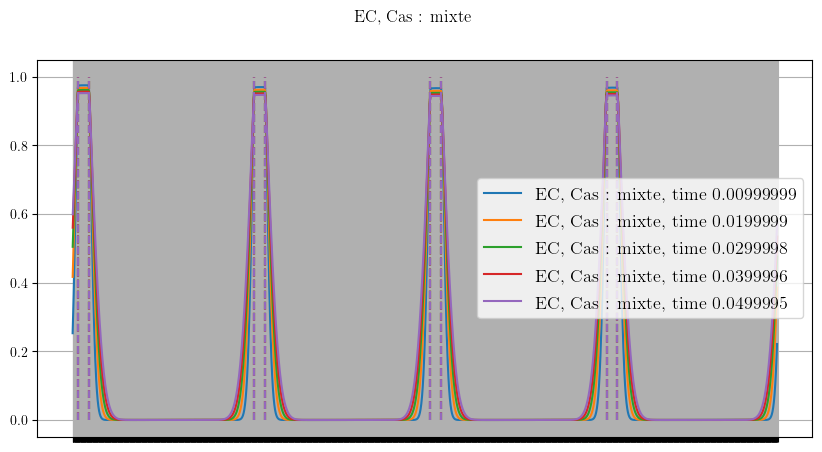

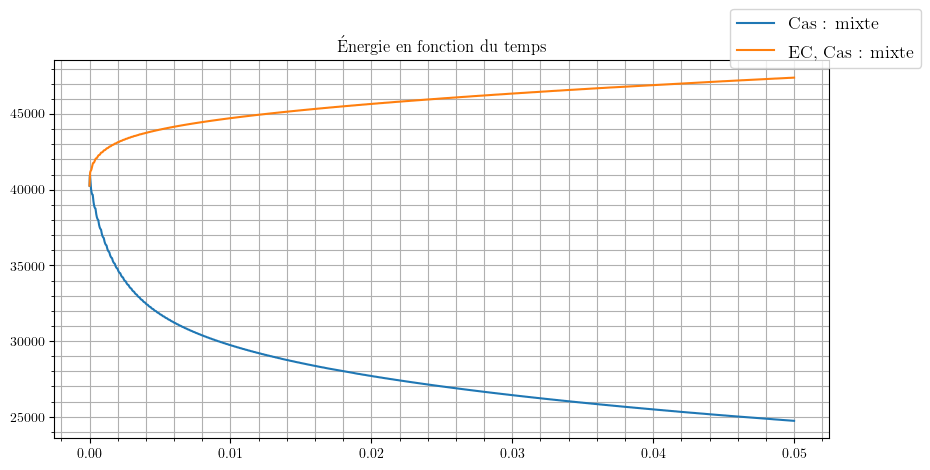

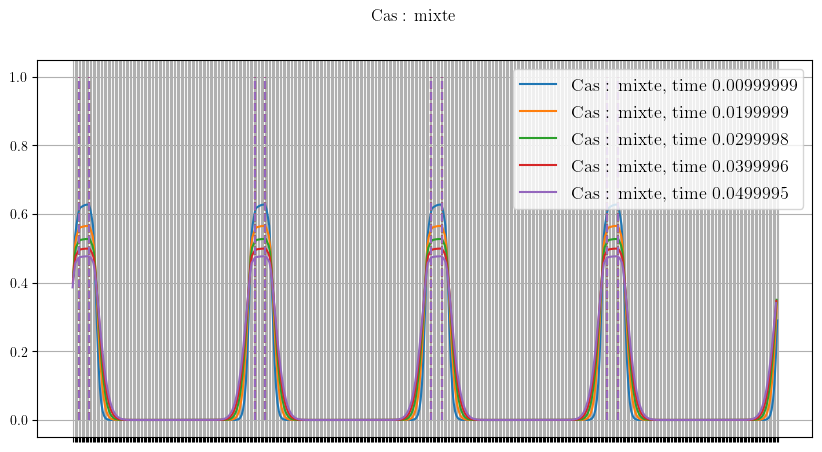

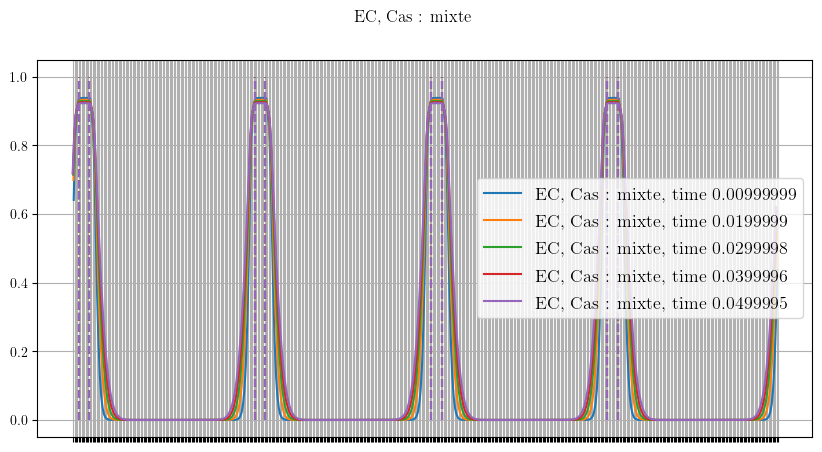

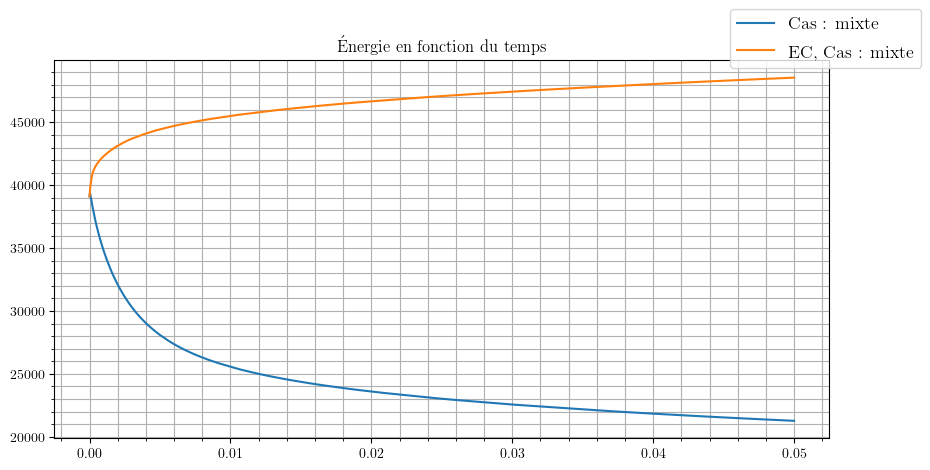

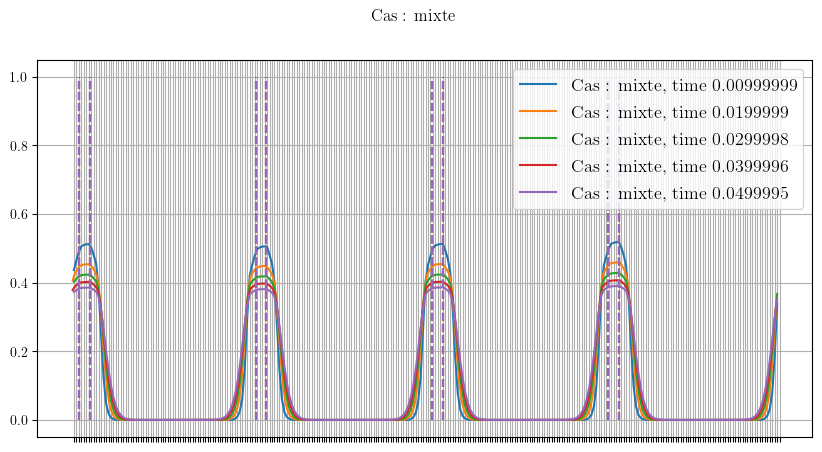

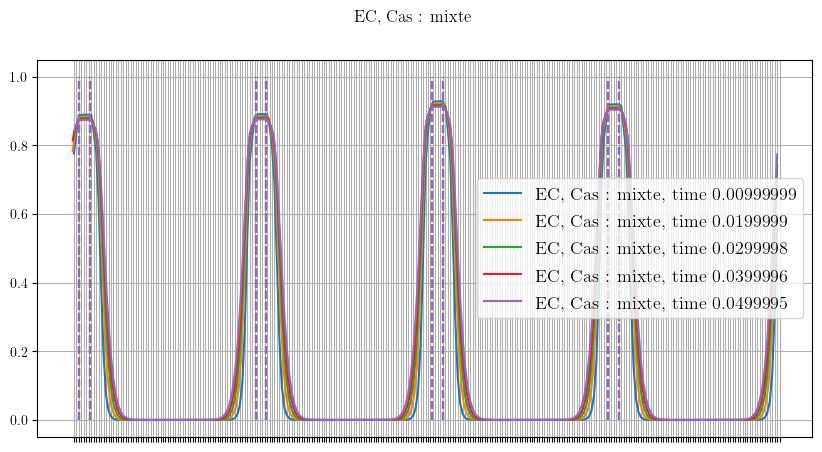

In [9]:
dx_list = [5*10**-6, 1*10**-5, 3.9*10**-5, 7*10**-5]
t_fin = 0.05
perte_e_dx = []
num_prop = NumericalProperties(dx=min(dx_list), schema='weno upwind', time_scheme='euler', phy_prop=phy_prop)
prob = Problem(get_T_creneau, markers=markers, num_prop=num_prop, phy_prop=phy_prop)
dt_min = prob.dt
for dx in dx_list:
    num_prop = NumericalProperties(dx=dx, dt=dt_min, schema='weno upwind', time_scheme='euler', phy_prop=phy_prop)
    perte_e_dx.append(compare_energy_forme(Formulation, phy_prop, num_prop, markers, t_fin))

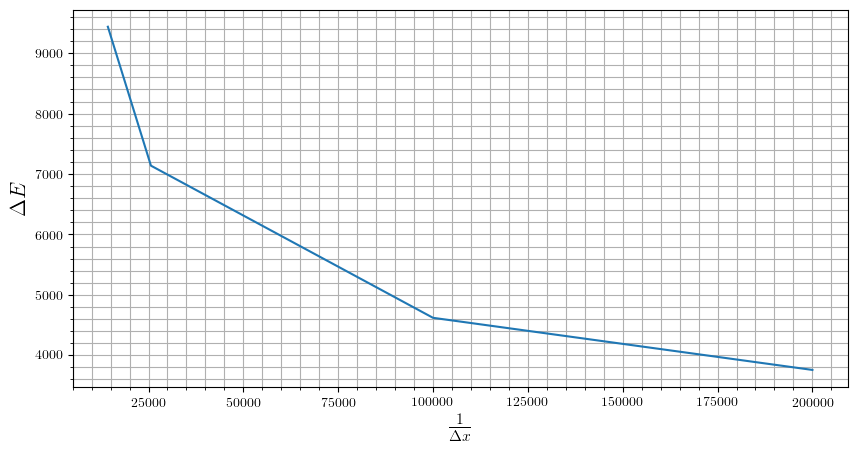

In [10]:
plt.plot(1./np.array(dx_list), np.array(perte_e_dx)/(0.02*0.005*0.005))
plt.xlabel(r'$\frac{1}{\Delta x}$', size=16)
plt.ylabel(r'$\Delta E$', size=16)
plt.grid(b=True, which='both')
plt.minorticks_on()

-0.3489537466899771


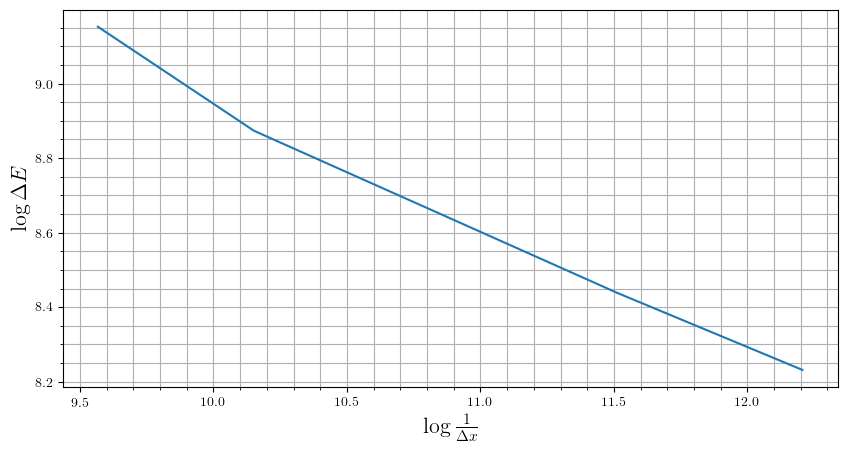

In [11]:
x = np.log(1./np.array(dx_list))
y = np.log(np.array(perte_e_dx)/(0.02*0.005*0.005))
plt.plot(x, y)
plt.xlabel(r'$\log{\frac{1}{\Delta x}}$', size=16)
plt.ylabel(r'$\log{\Delta E}$', size=16)
plt.grid(b=True, which='both')
plt.minorticks_on()
print((y[-1] - y[0])/(x[-1] - x[0]))

## Étude en $\Delta t$

Ici on ne change pas $\Delta x$, mais on diminue dt_min pour qu'il soit contraignant


dt fourier
1.6355326555849658e-05
Cas : mixte
dE*/dt* = -4.11231e-05

dt fourier
1.6355326555849658e-05
EC, Cas : mixte
dE*/dt* = 2.73256e-05

dt min
1e-05
Cas : mixte
dE*/dt* = -2.63665e-05

dt min
1e-05
EC, Cas : mixte
dE*/dt* = 1.74224e-05

dt min
4.9999999999999996e-06
Cas : mixte
dE*/dt* = -1.36516e-05

dt min
4.9999999999999996e-06
EC, Cas : mixte
dE*/dt* = 8.95768e-06


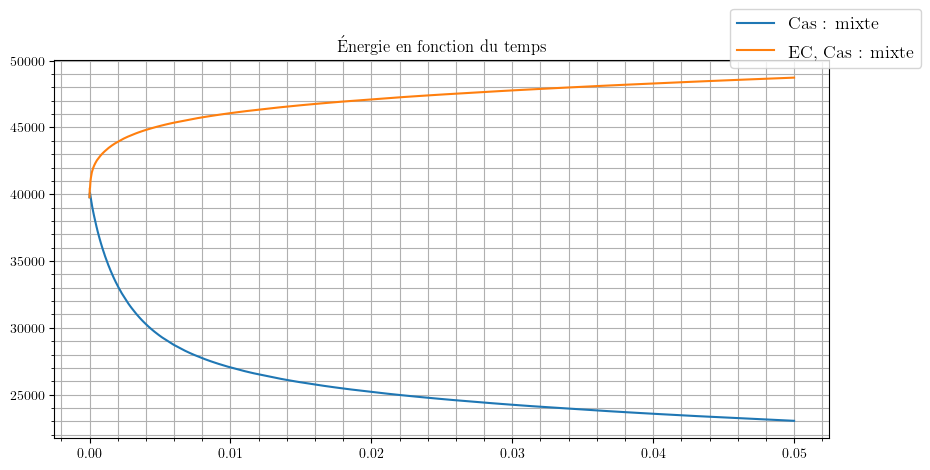

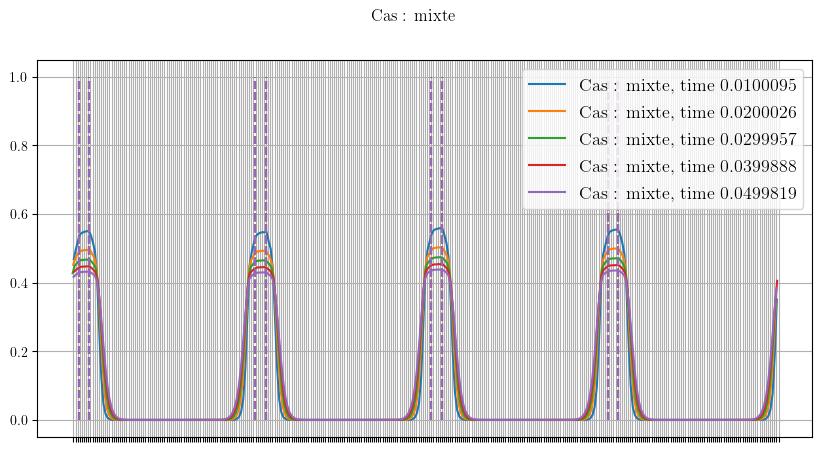

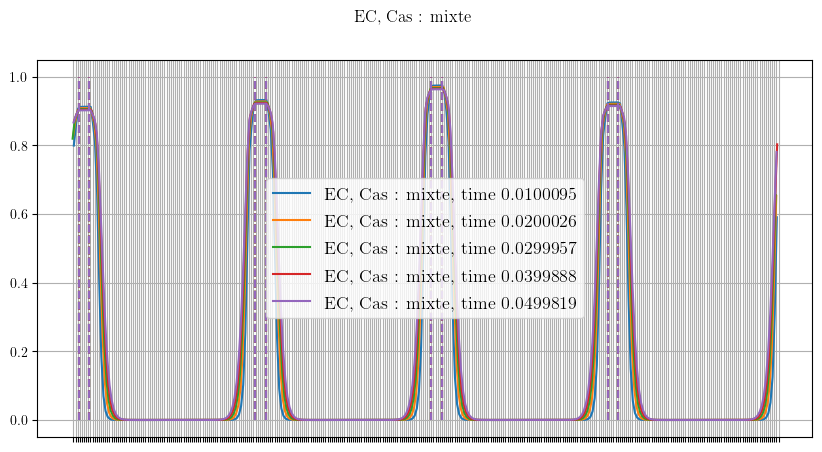

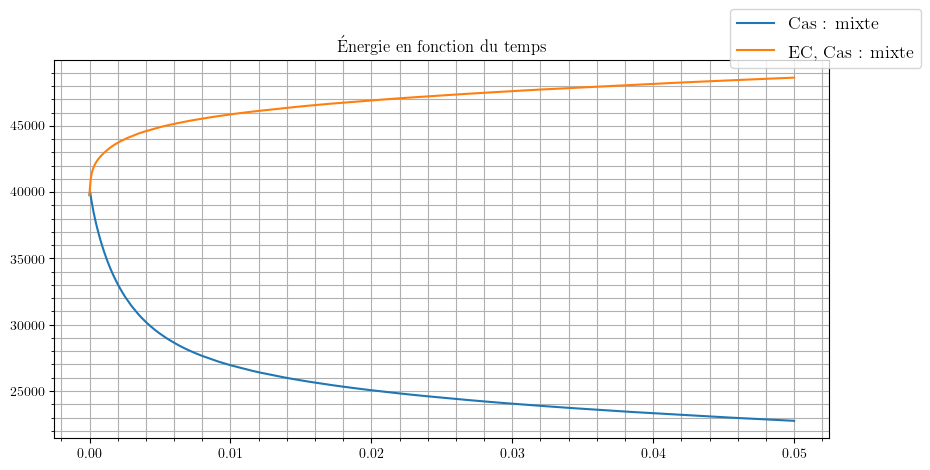

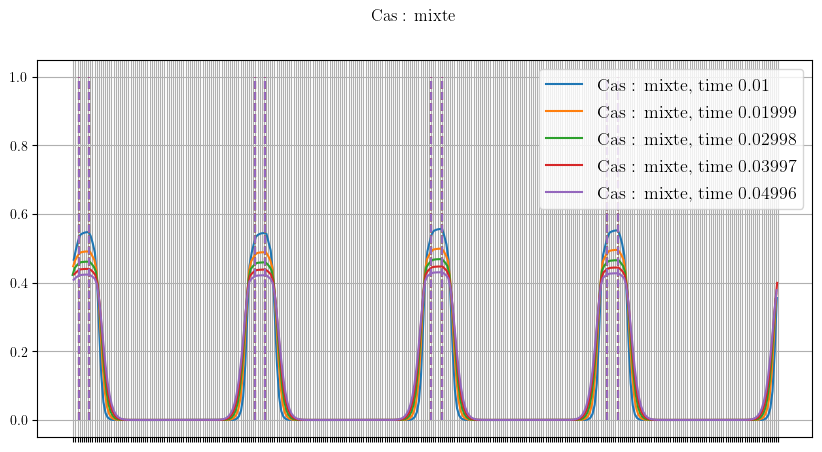

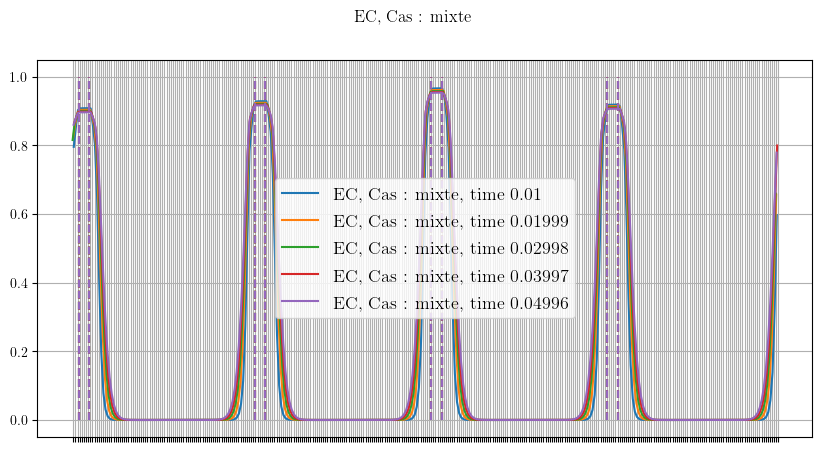

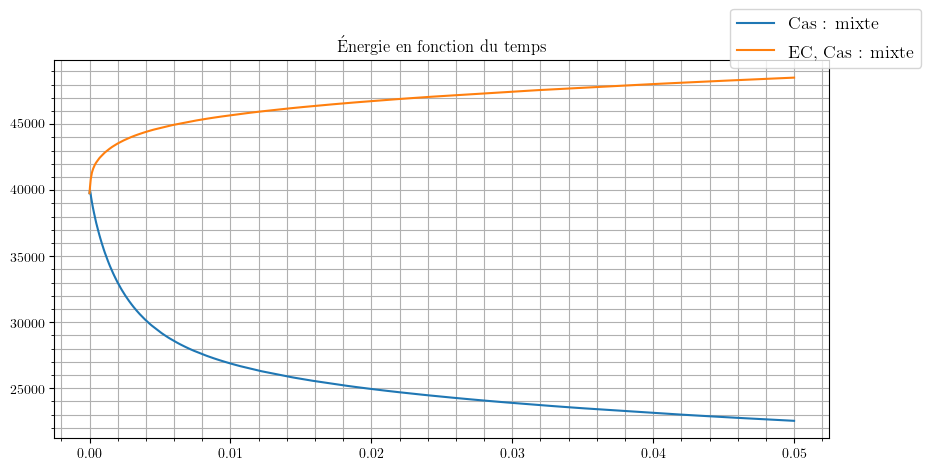

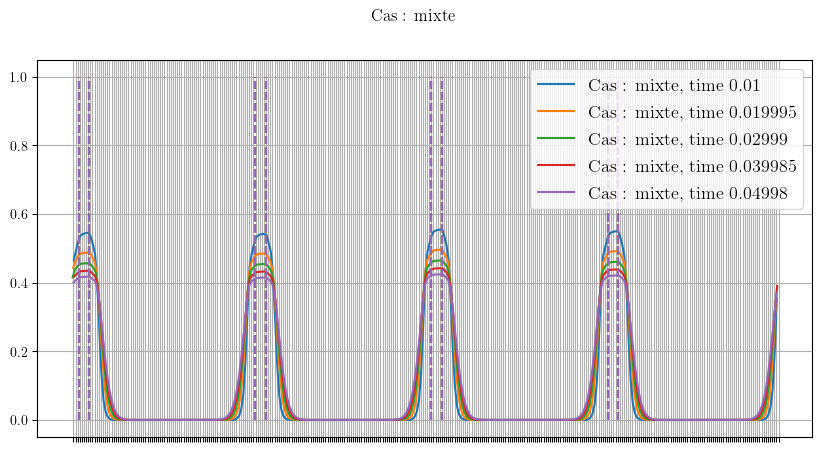

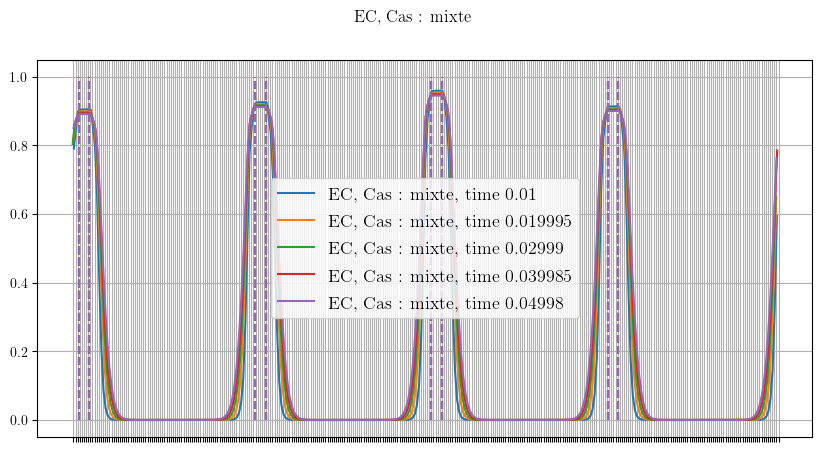

In [12]:
dt_min_list = [2*10**-5, 1*10**-5, 5*10**-6]
dt_list = []
t_fin = 0.05
perte_e_dt = []
for dt in dt_min_list:
    num_prop = NumericalProperties(dx=6*10**-5, schema='weno upwind', time_scheme='euler', phy_prop=phy_prop, dt=dt)
    perte_e_dt.append(compare_energy_forme(Formulation, phy_prop, num_prop, markers, t_fin, dt_list))

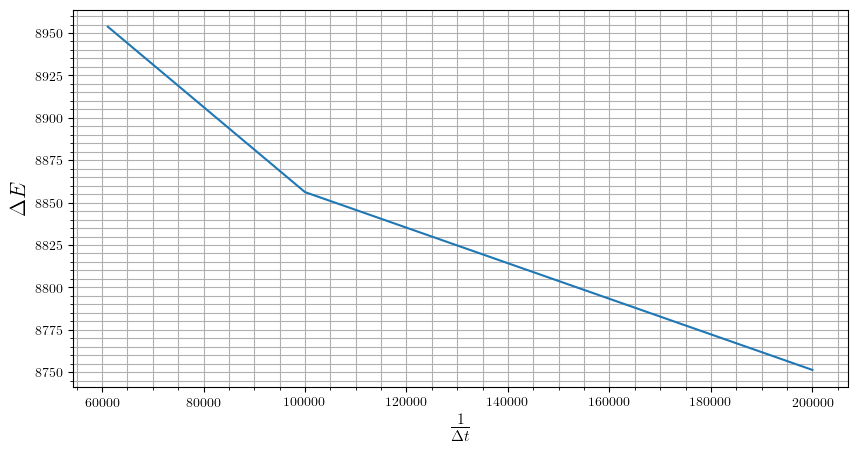

In [15]:
plt.plot(1./np.array(dt_list[::2]), np.array(perte_e_dt)/(0.02*0.005*0.005))
plt.xlabel(r'$\frac{1}{\Delta t}$', size=16)
plt.ylabel(r'$\Delta E$', size=16)
plt.grid(b=True, which='both')
plt.minorticks_on()

-0.019286948187487604


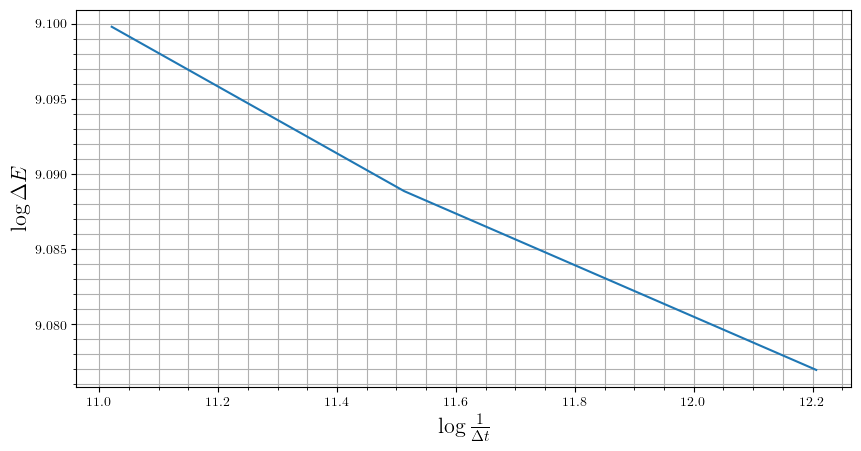

In [16]:
x = np.log(1./np.array(dt_list[::2]))
y = np.log(np.array(perte_e_dt)/(0.02*0.005*0.005))
plt.plot(x, y)
plt.xlabel(r'$\log{\frac{1}{\Delta t}}$', size=16)
plt.ylabel(r'$\log{\Delta E}$', size=16)
plt.grid(b=True, which='both')
plt.minorticks_on()
print((y[-1] - y[0])/(x[-1] - x[0]))

On n'observe pas de différence notable entre les simulations. Cela laisse à penser que seul le maillage spatial permet de diminuer les pertes d'énergie.

Essayons d'analyser les sources de perte d'énergie.


# Étude qualitative

## Pertes en diffusion pure


dt fourier
2.232841866976439e-05
Cas : diffusion
dE*/dt* = 1.06718e-05

dt fourier
2.232841866976439e-05
EC, Cas : diffusion
dE*/dt* = -9.90688e-19


-6.938893903907228e-18

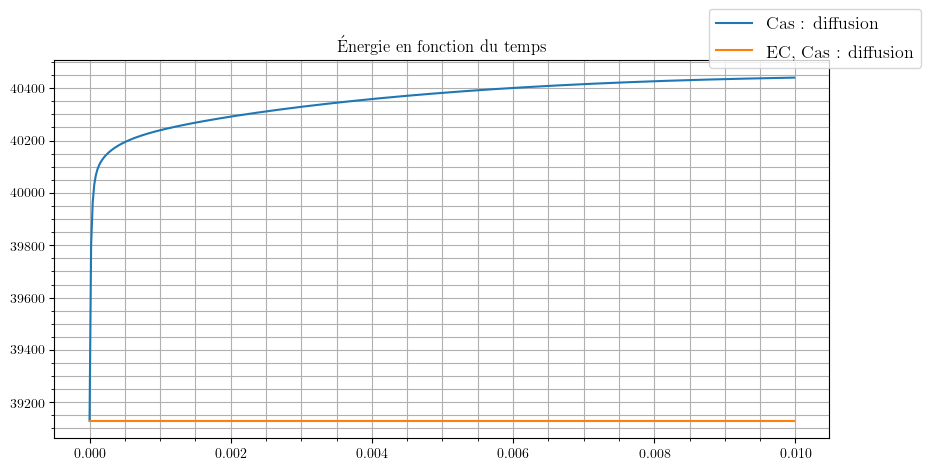

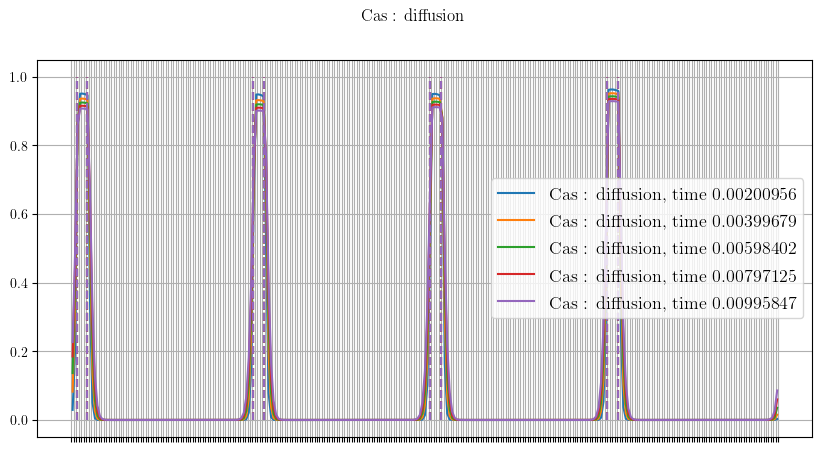

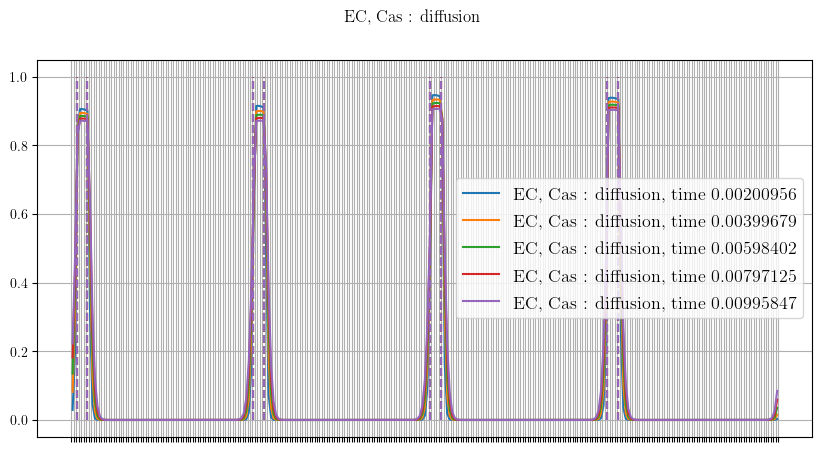

In [17]:
t_fin = 0.01
phy_prop = PhysicalProperties(Delta=0.02, v=0., dS=0.005**2,
                              lda1=5.5*10**-2, lda2=15.5, rho_cp1=70278., rho_cp2=702780., diff=1.,
                              alpha=0.06, a_i=357.)
num_prop = NumericalProperties(dx=7*10**-5, schema='weno upwind', time_scheme='euler', phy_prop=phy_prop)
compare_energy_forme(Formulation, phy_prop, num_prop, markers, t_fin)

## Perte d'énergie en convection pure


dt fourier
2.232841866976439e-05
Cas : convection
dE*/dt* = -0.000576189

dt fourier
2.232841866976439e-05
EC, Cas : convection
dE*/dt* = 0.000165675


0.0035462448450099965

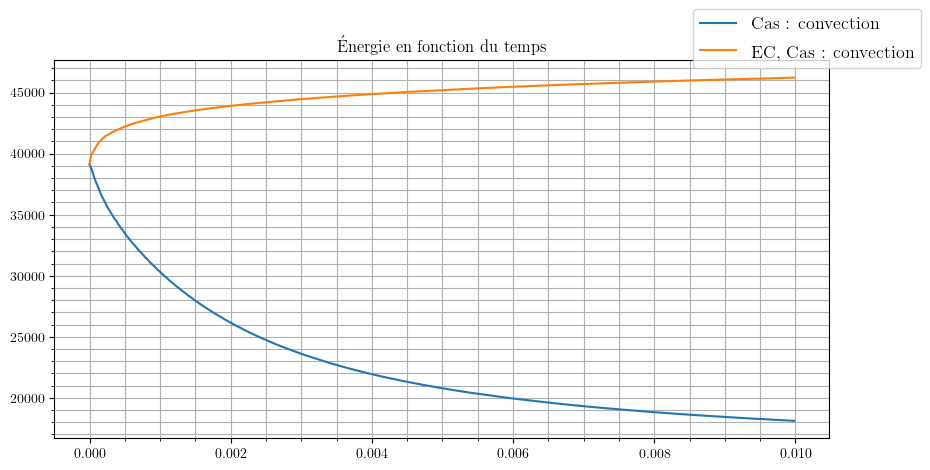

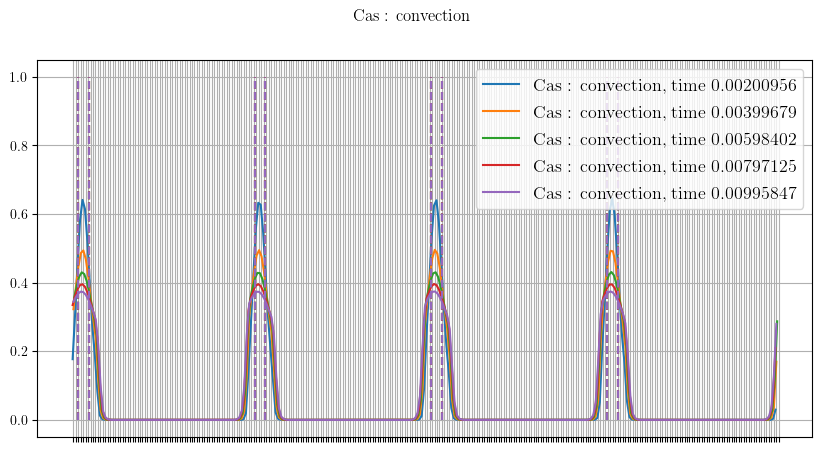

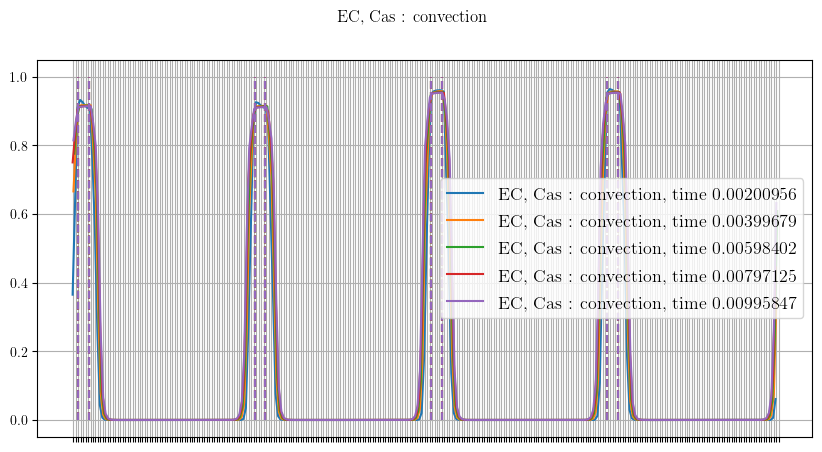

In [18]:
t_fin = 0.01
phy_prop = PhysicalProperties(Delta=0.02, v=0.2, dS=0.005**2,
                              lda1=5.5*10**-2, lda2=15.5, rho_cp1=70278., rho_cp2=702780., diff=0.,
                              alpha=0.06, a_i=357.)
num_prop = NumericalProperties(dx=7*10**-5, schema='weno upwind', time_scheme='euler', phy_prop=phy_prop)
compare_energy_forme(Formulation, phy_prop, num_prop, markers, t_fin)

## Étude selon les schémas numériques

In [27]:
Schemas = ['upwind', 'center', 'weno', 'weno upwind']
Time_scheme = ['euler', 'rk4']
def compare_energy_schema(schemas, form, time_scheme, phy_prop, markers, t_fin):
    fig1,ax1 = plt.subplots(1)
    ax1.set_title('Énergie en fonction du temps')
    for schem in schemas:
        for ts in time_scheme:
            a = Plotter('decale')
            num_prop = NumericalProperties(dx=4*10**-5, schema=schem, time_scheme=ts, phy_prop=phy_prop)
            print()
            prob = form(get_T_creneau, markers, phy_prop=phy_prop, num_prop=num_prop)
            E0 = prob.energy
            print(prob.name)
            print('==========================')
            t, e = prob.timestep(t_fin=t_fin, number_of_plots=5, debug=None, plotter=a)
            a.ax.set_xlim(0., phy_prop.Delta/2)
            a.ax.set_ylim(0.6, 1.1)
            l = ax1.plot(t, e/(0.02*0.005*0.005), label=prob.name)
            n = len(e)
            i0 = int(n/5)
            dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob.dt / E0  # on a mult
            # par Dt / rho_cp_l T_l V
            print('dE*/dt* = %f' % dedt_adim)
    le = fig1.legend()
    ax1.minorticks_on()
    ax1.grid(b=True, which='both')


dt fourier
7.283608525474247e-06
Cas : convection

dt fourier
1.1335161290322582e-07
Cas : convection
dE*/dt* = -0.000000


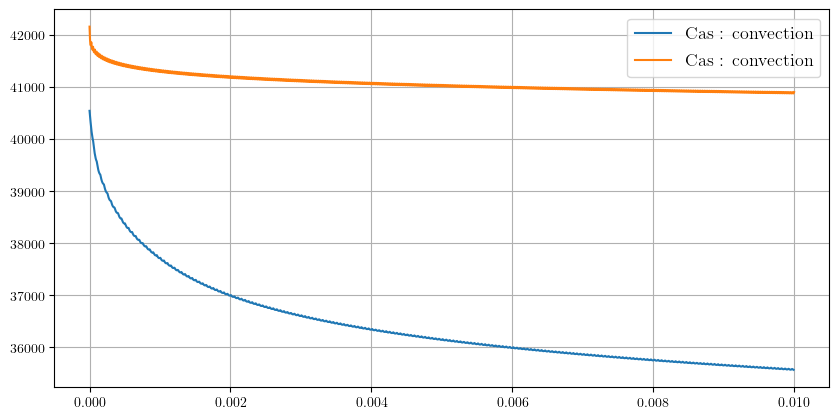

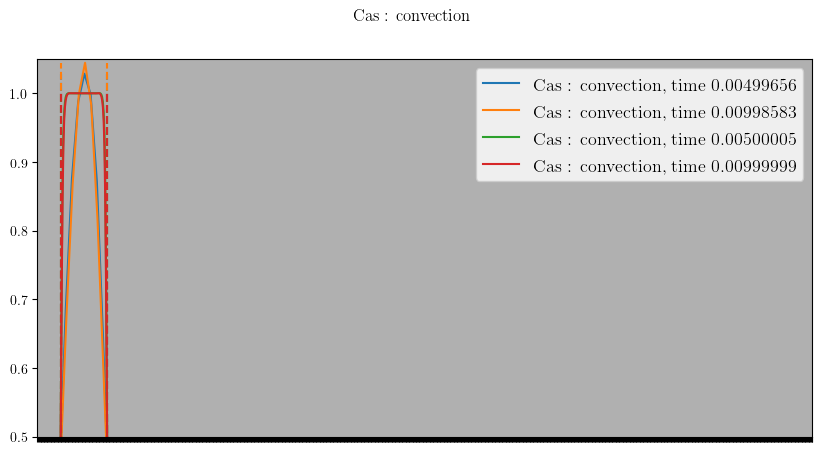

In [25]:
t_fin = 0.01
fig1, ax1 = plt.subplots(1)
a = Plotter('decale')
num_prop = NumericalProperties(dx=4*10**-5, schema='weno', time_scheme='rk4', phy_prop=phy_prop)
print()
prob_ref = Problem(get_T_creneau, markers, phy_prop=phy_prop, num_prop=num_prop)
E0 = prob_ref.energy
print(prob_ref.name)
print('==========================')
t, e = prob_ref.timestep(t_fin=t_fin, number_of_plots=2, debug=None, plotter=a)
a.ax.set_ylim(0.5,1.05)
a.ax.set_xlim(0., phy_prop.Delta/4.)
l = ax1.plot(t, e/(0.02*0.005*0.005), label=prob_ref.name)
ax1.legend()
ax1.grid(b=True)
n = len(e)
i0 = int(n/5)
dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob_ref.dt / E0  # on a mult

num_prop = NumericalProperties(dx=5*10**-6, schema='weno', time_scheme='rk4', phy_prop=phy_prop)
print()
prob_ref = Problem(get_T_creneau, markers, phy_prop=phy_prop, num_prop=num_prop)
E0 = prob_ref.energy
print(prob_ref.name)
print('==========================')
t, e = prob_ref.timestep(t_fin=t_fin, number_of_plots=2, debug=None, plotter=a)
a.ax.set_ylim(0.5,1.05)
a.ax.set_xlim(0., phy_prop.Delta/4.)
l = ax1.plot(t, e/(0.02*0.005*0.005), label=prob_ref.name)
ax1.legend()
ax1.grid(b=True)
n = len(e)
i0 = int(n/5)
dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob_ref.dt / E0  # on a mult
# par Dt / rho_cp_l T_l V
print('dE*/dt* = %f' % dedt_adim)


dt fourier
7.283608525474247e-06
Cas : convection
dE*/dt* = -0.000236

dt fourier
7.283608525474247e-06
Cas : convection
dE*/dt* = -0.000237

dt fourier
7.283608525474247e-06
Cas : convection
dE*/dt* = -0.000008

dt fourier
7.283608525474247e-06
Cas : convection
dE*/dt* = -0.000032

dt fourier
7.283608525474247e-06
Cas : convection
dE*/dt* = -0.000170

dt fourier
7.283608525474247e-06
Cas : convection
dE*/dt* = -0.000170


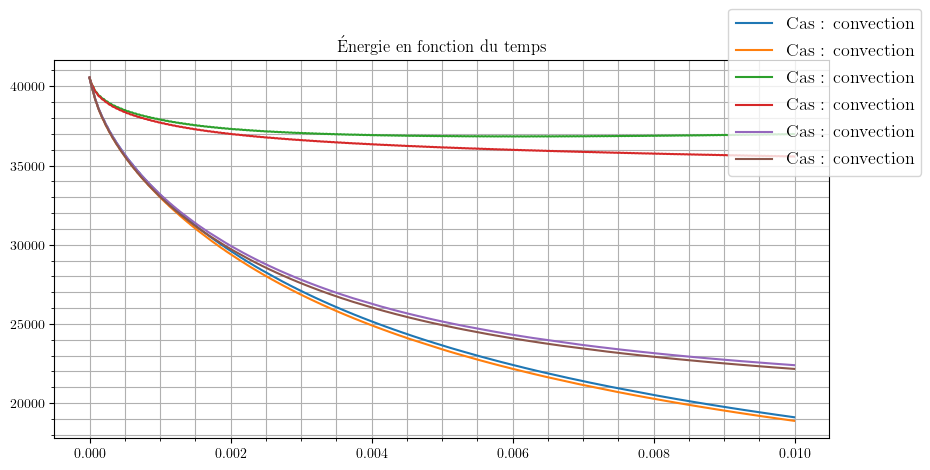

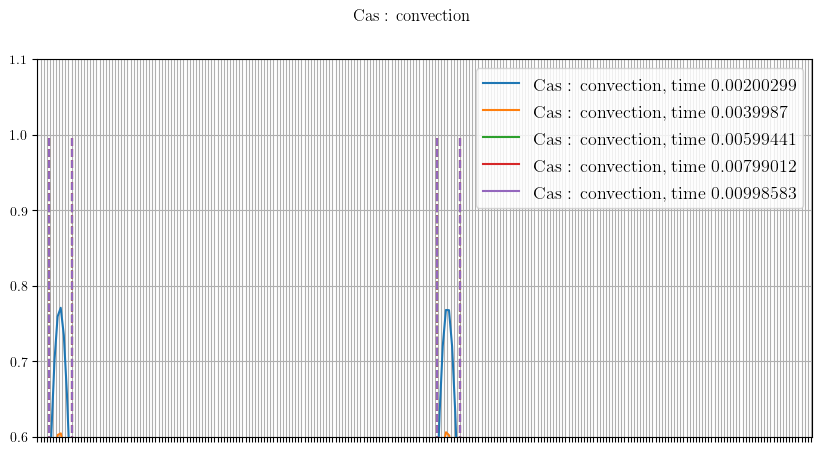

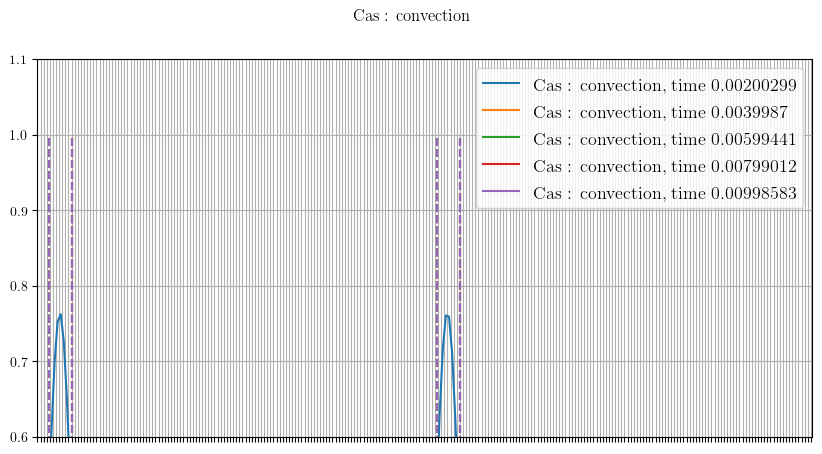

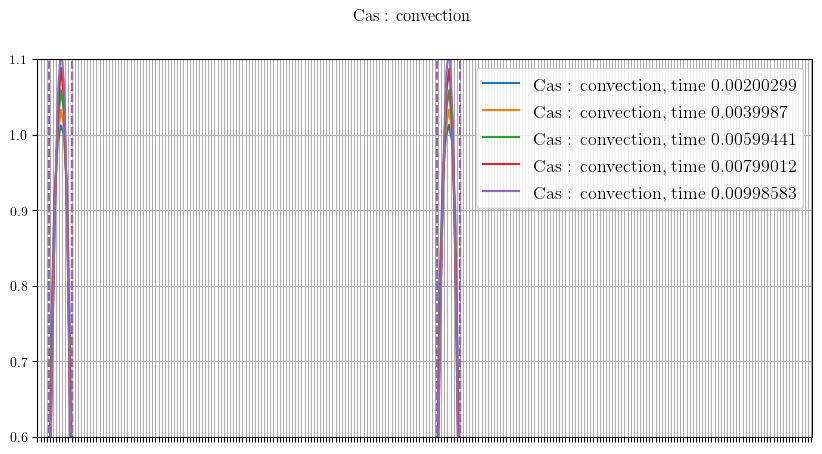

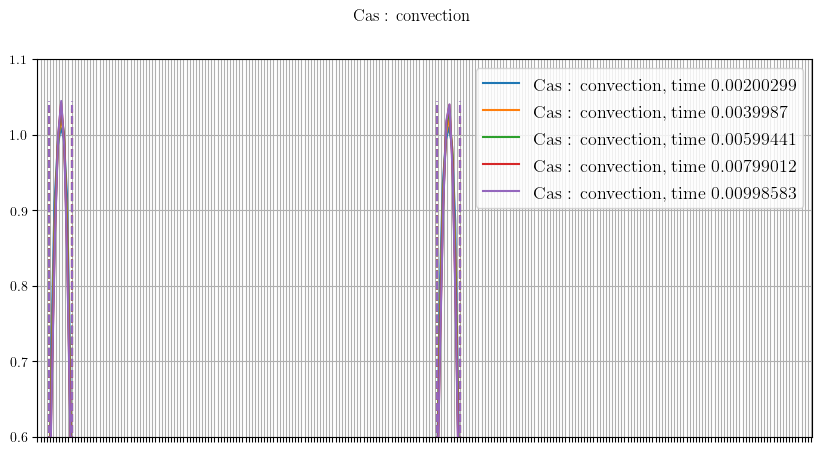

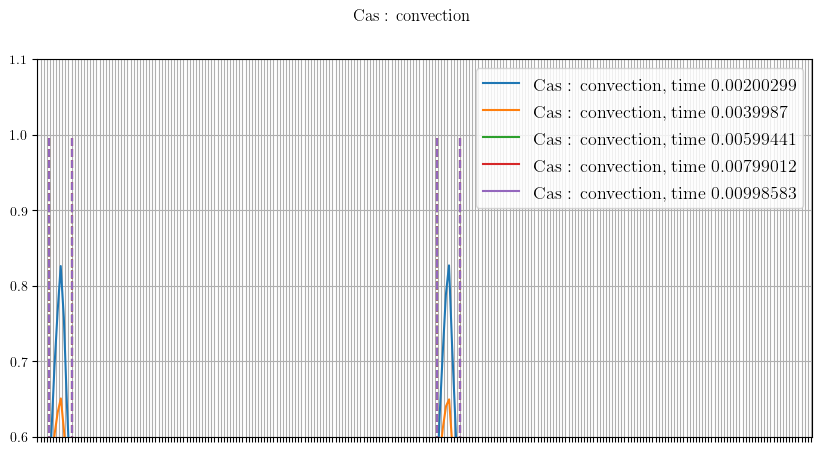

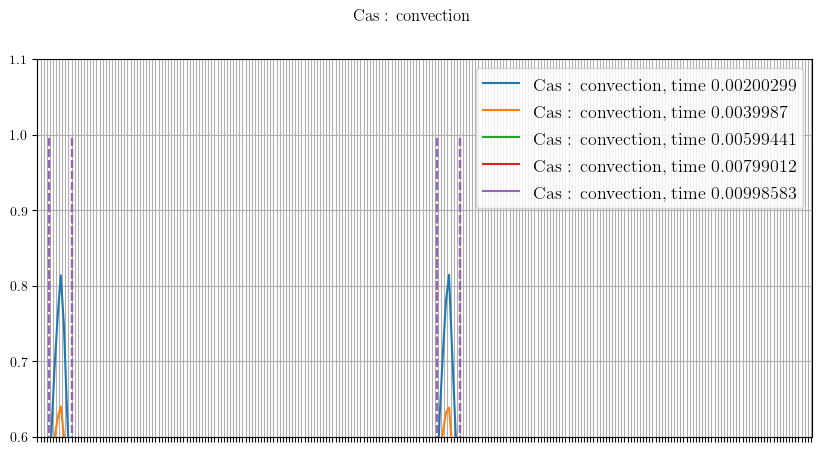

In [28]:
t_fin = 0.01
Schemas = ['upwind', 'weno', 'weno upwind']
compare_energy_schema(Schemas, Problem, Time_scheme, phy_prop, markers, t_fin)


dt fourier
7.283608525474247e-06
EC, Cas : convection
dE*/dt* = 0.000067

dt fourier
7.283608525474247e-06
EC, Cas : convection
dE*/dt* = 0.000065

dt fourier
7.283608525474247e-06
EC, Cas : convection
dE*/dt* = 0.000023

dt fourier
7.283608525474247e-06
EC, Cas : convection
dE*/dt* = 0.000036

dt fourier
7.283608525474247e-06
EC, Cas : convection
dE*/dt* = 0.000032

dt fourier
7.283608525474247e-06
EC, Cas : convection
dE*/dt* = 0.000033


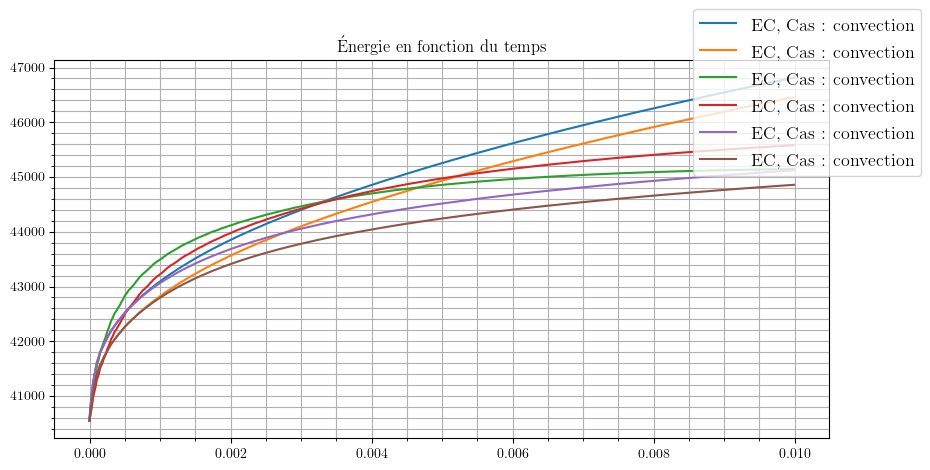

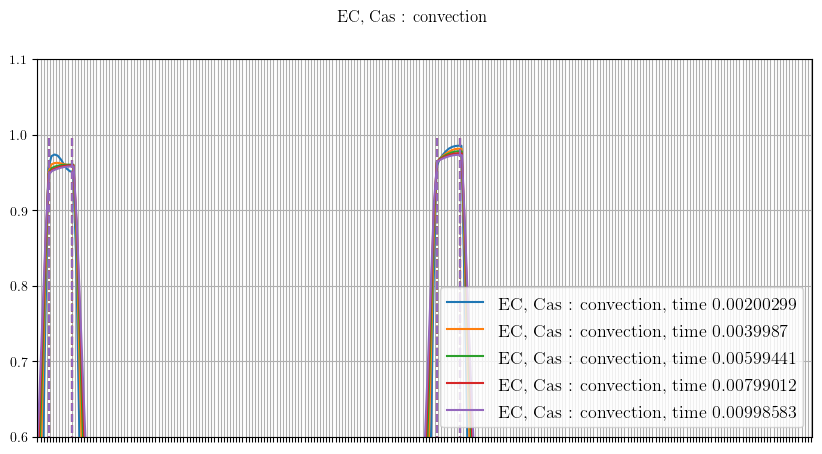

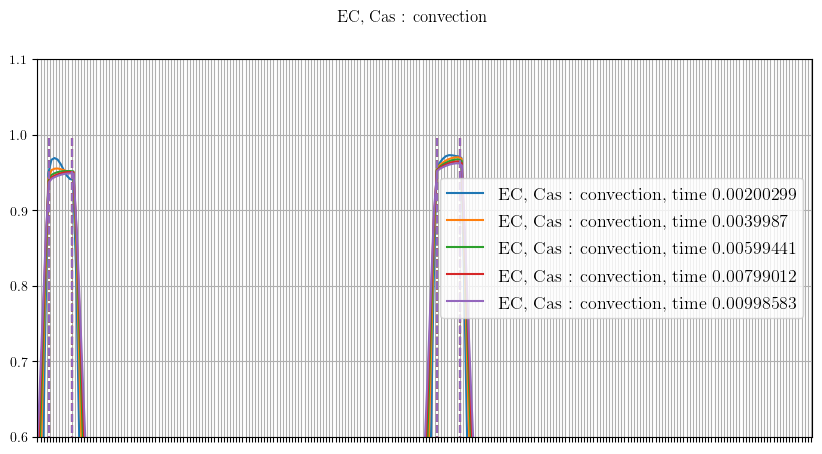

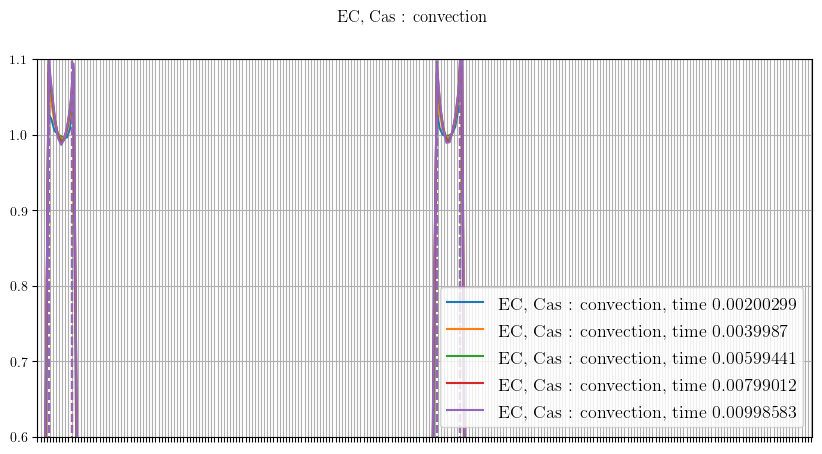

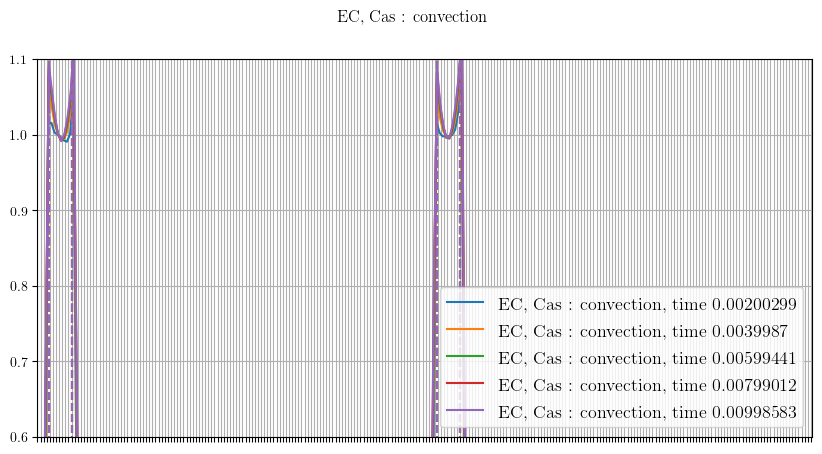

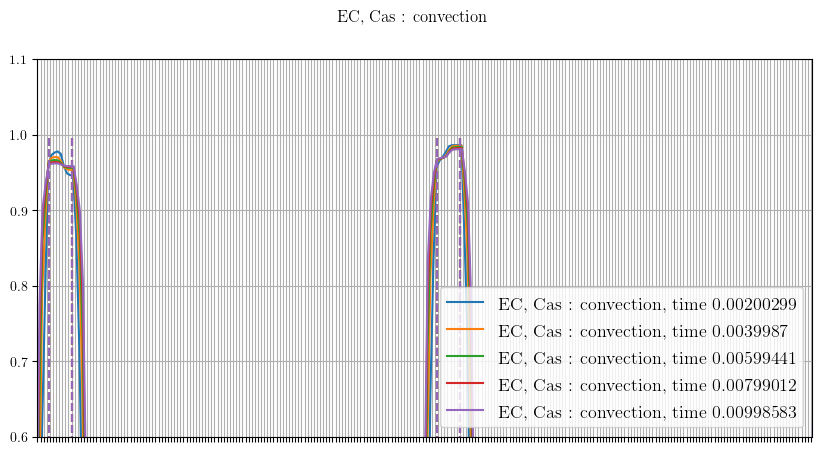

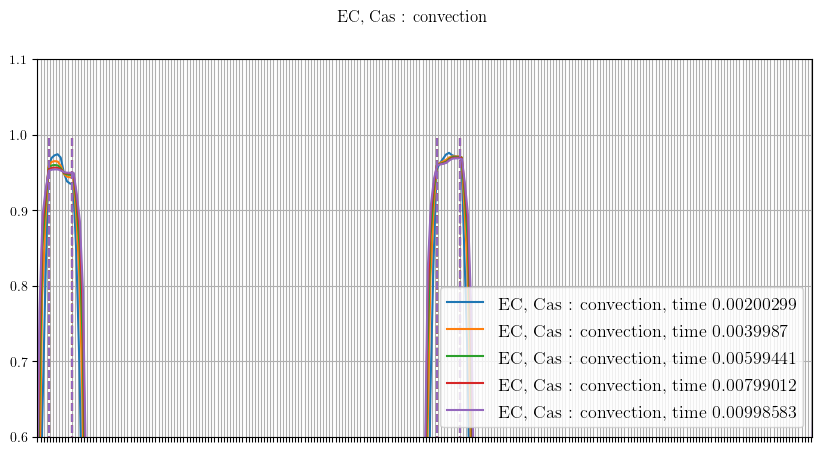

In [29]:
Schemas = ['upwind', 'weno', 'weno upwind']
Time_scheme = ['euler', 'rk4']
compare_energy_schema(Schemas, ProblemConserv2, Time_scheme, phy_prop, markers, t_fin)

# Profiling du code

In [30]:
from line_profiler import LineProfiler
num_prop = NumericalProperties(dx=7*10**-5, schema='weno upwind', time_scheme='rk4', phy_prop=phy_prop, dt=1.)
lp = LineProfiler()
func = [Problem.rk4_timestep, Bulles.indicatrice_liquide, interpolate_form_center_to_face_weno,
       integrale_volume_div]
for fu in func:
    lp.add_function(fu)   # add additional function to profile
lp_wrapper = lp(compare_energy_forme)
lp_wrapper(Formulation, phy_prop, num_prop, markers, 0.1)
lp.print_stats()

NameError: name 'interpolate_form_center_to_face_weno' is not defined

# Comparaison des meilleurs cas pour chaque formulation

In [ ]:
t_fin = 0.2
fig1, ax1 = plt.subplots(1)

for dx in [2*10**-5, 4*10**-5, 7*10**-5, 10*10**-5]:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
    a = Plotter('decale')
    num_prop = NumericalProperties(dx=dx, schema='weno', time_scheme='rk4', phy_prop=phy_prop)
    print()
    prob_ref = Problem(get_T_creneau, markers, phy_prop=phy_prop, num_prop=num_prop)
    E0 = prob_ref.energy_m
    print(prob_ref.name)
    print('==========================')
    t, e = prob_ref.timestep(t_fin=t_fin, number_of_plots=2, debug=False, plotter=a)
    l = ax1.plot(t, e, label=prob_ref.name)
    n = len(e)
    i0 = int(n/5)
    dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob_ref.dt / E0  # on a mult
    print('dE/dt = %g' % dedt_adim)

    num_prop = NumericalProperties(dx=dx, schema='weno upwind', time_scheme='rk4', phy_prop=phy_prop)
    print()
    prob_ref = ProblemConserv2(get_T_creneau, markers, phy_prop=phy_prop, num_prop=num_prop)
    E0 = prob_ref.energy_m
    print(prob_ref.name)
    print('==========================')
    t, e = prob_ref.timestep(t_fin=t_fin, number_of_plots=2, debug=False, plotter=a)
    l = ax1.plot(t, e, label=prob_ref.name)
    n = len(e)
    i0 = int(n/5)
    dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob_ref.dt 
    print('dE/dt = %g' % dedt_adim)
    
    a.ax.set_ylim(0.,1.05)
    a.ax.set_xlim(0., phy_prop.Delta/4.)
    ax1.legend()
    ax1.grid(b=True)

In [ ]:
markers.shift(10**-6/7.)

In [ ]:
%matplotlib inline
rc('figure', figsize=(10,7))
rc('figure', dpi=100)
n = 1000
t_fin = 10**-6
fig1, ax1 = plt.subplots(1)


for dx in [5*10**-6, 4*10**-6, 3*10**-6, 2*10**-6, 1*10**-6]:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
    a = Plotter('decale')
    num_prop = NumericalProperties(dx=dx, schema='weno', time_scheme='rk4', phy_prop=phy_prop)
    print()
    prob_ref = Problem(get_T_creneau, markers=markers, phy_prop=phy_prop, num_prop=num_prop)
    E0 = prob_ref.energy
    print(prob_ref.name)
    print('==========================')
    t, e = prob_ref.timestep(n=n, t_fin=t_fin, number_of_plots=1, plotter=a)
    l = ax1.plot(t, e/(0.02*0.005*0.005), label=prob_ref.name)
    n = len(e)
    i0 = int(n/5)
    dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob_ref.dt / E0  # on a mult
    print('dE/dt = %g' % dedt_adim)

    num_prop = NumericalProperties(dx=dx, schema='weno upwind', time_scheme='rk4', phy_prop=phy_prop)
    print()
    prob_ref = ProblemConserv2(get_T_creneau, markers=markers, phy_prop=phy_prop, num_prop=num_prop)
    E0 = prob_ref.energy
    print(prob_ref.name)
    print('==========================')
    t, e = prob_ref.timestep(t_fin=t_fin, n=n, number_of_plots=1, plotter=a)
    l = ax1.plot(t, e/(0.02*0.005*0.005), label=prob_ref.name)
    n = len(e)
    i0 = int(n/5)
    dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob_ref.dt 
    print('dE/dt = %g' % dedt_adim)
    
    a.ax.set_ylim(0.94,1.02)
    a.ax.set_xlim(prob_ref.markers.markers[0][0] - prob_ref.markers.diam / 4., prob_ref.markers.markers[0][0] + prob_ref.markers.diam / 2.,)
    ax1.legend()
    ax1.grid(b=True, which='both')